**1. Import Libraries and Set Up Environment**

In [2]:
# Install necessary libraries
!pip install onnx
!pip install onnxruntime


# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import onnxruntime as ort





# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.7 MB/s eta 0:00:00
Using device: cpu


**2. Load and Prepare Dataset**

In [3]:
# Load dataset
posts_file = "Posts.txt"
labels_file = "Labels.txt"

# Read posts and labels
with open(posts_file, 'r', encoding='utf-8') as f:
    posts = f.readlines()

with open(labels_file, 'r', encoding='utf-8') as f:
    labels = f.readlines()

# Clean data
posts = [post.strip() for post in posts]
labels = [1 if label.strip().lower() == 'hate' else 0 for label in labels]

# Convert to DataFrame
data = pd.DataFrame({'post': posts, 'label': labels})
print(data.head())


                                                post  label
0  አስቀድሜ ጥያቄዬ በጨዋነት በውስጥ መስመር እንዲደርስዎ አድርጌ ፍትህን ለ...      0
1  እነዚህን ወሳኝ ጉዳዮችን የሚያስፈፅም አካል እንዲቋቋምና ክትትል እንዲደረ...      0
2  የአማራ ህዝብ በአእምሮ ክንፉ ያልበረረበት ጥበብና ፍልስፍና ያልከፈተው የ...      0
3  ከአማራ ህዝብ የሀገሪቱ ዘርፈ ብዙ እውቀት መንጭቶ የሞላበትከሙላቱም በመል...      0
4  ዛሬ በየትኛውም መለኪያ ይሁን መመዘኛ ኢትዮጵያዊነት የሚንፀባረቀው በአማራ...      1


**3.Tokenization and Word2Vec Embedding**

In [106]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import nltk
import numpy as np
import pandas as pd


### 1. Tokenize Posts
nltk.download('punkt_tab')
data['tokens'] = data['post'].apply(word_tokenize)

print("Step 1: Tokenized Posts")
print(data['tokens'])
print("-" * 50)

### 2. Train Word2Vec
embedding_dim = 100
word2vec = word2vec = Word2Vec(
    sentences=data['tokens'],
    vector_size=100,        # Increased dimension
    window=5,               # Larger context
    min_count=1,            # Ignore rare words
    workers=4,
    sg=1,                   # Use skip-gram for better semantic relations
    negative=10,            # More negative samples
    epochs=30               # More iterations
)

print("Step 2: Word2Vec Vocabulary")
print(word2vec.wv.index_to_key)  # List of words in the vocabulary
print("-" * 50)

### 3. Create Embedding Matrix
vocab = word2vec.wv
embedding_matrix = {word: vocab[word] for word in vocab.index_to_key}

print("Step 3: Embedding Matrix (First 5 Words)")
for i, (word, vec) in enumerate(embedding_matrix.items()):
    print(f"Word: {word} -> Vector: {vec[:5]}...")  # Print first 5 values of the vector
    if i >= 4:
        break
print("-" * 50)

### 4. Function to Vectorize Posts
def vectorize_post(tokens, embedding_matrix, max_len=10):
    vectors = [embedding_matrix[token] if token in embedding_matrix else np.zeros(embedding_dim) for token in tokens]
    # Pad or truncate to max_len
    if len(vectors) > max_len:
        vectors = vectors[:max_len]
    else:
        vectors.extend([np.zeros(embedding_dim)] * (max_len - len(vectors)))
    return np.array(vectors)

# Vectorizing one post for demonstration
print("Step 4: Example Post Vectorization")
example_post = data['tokens'][0]
example_vector = vectorize_post(example_post, embedding_matrix, max_len=10)  # Use max_len=10 for brevity
print(f"Example Post: {example_post}")
print(f"Vectorized Post (Shape {example_vector.shape}):")
print(example_vector[:3])  # Print first 3 vectors
print("-" * 50)

### 5. Vectorize All Posts
max_len = 50
data['vectors'] = data['tokens'].apply(lambda x: vectorize_post(x, embedding_matrix, max_len))

print("Step 5: All Posts Vectorized (First Example)")
print(f"Shape: {data['vectors'][0].shape}")
print(data['vectors'][0][:3])  # Print first 3 vectors of the first post
print("-" * 50)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Step 1: Tokenized Posts
0        [አስቀድሜ, ጥያቄዬ, በጨዋነት, በውስጥ, መስመር, እንዲደርስዎ, አድርጌ...
1        [እነዚህን, ወሳኝ, ጉዳዮችን, የሚያስፈፅም, አካል, እንዲቋቋምና, ክትት...
2        [የአማራ, ህዝብ, በአእምሮ, ክንፉ, ያልበረረበት, ጥበብና, ፍልስፍና, ...
3        [ከአማራ, ህዝብ, የሀገሪቱ, ዘርፈ, ብዙ, እውቀት, መንጭቶ, የሞላበትከ...
4        [ዛሬ, በየትኛውም, መለኪያ, ይሁን, መመዘኛ, ኢትዮጵያዊነት, የሚንፀባረ...
                               ...                        
29995    [በአሉ, የሁሉም, ኢትዮጵያዊ, ስላልሆነ, በኦሮምኛው, ቢለፋደድ, ምን, ...
29996      [ተባረክ, አብቹ, ፈር, ቀዳጅ, ስለሆንህ, መጋረጃው, መቀደድ, ስለጀመረ]
29997    [እስከ, አሁን, አንተ, ብቻ, ነው, በ, መፅሀፍ, ያልቻልከው, አንተም,...
29998    [ህገወጥት, ጠቅላይ, ሚንስትር, ፅቤት, የተፈቀደ, ሆኖ, ህዝብን, እንዴ...
29999    [ደነዙ, ጠቅላይ, ሚንስትር, ፅቤት, ህገመንግስት, ሳይሻሻል, በህግ, የ...
Name: tokens, Length: 30000, dtype: object
--------------------------------------------------
Step 2: Word2Vec Vocabulary
['ነው', 'ላይ', 'ግን', 'እና', 'ህዝብ', 'ምን', 'ነገር', 'ሰው', 'አንተ', 'ነበር', 'ብቻ', 'አማራ', 'ነዉ', 'ጋር', 'አሁን', 'እንደ', 'ወደ', 'ይህ', 'ማለት', 'እንጂ', 'መንግስት', 'አንድ', 'ደግሞ', 'እኮ', 'ሁሉ', 'በጣም', 'እንኳን', 'አይደለም', 'ውስጥ', 'ብሎ', 'ለም

In [107]:
word2vec.wv.similarity('ጠቅላይ', 'ሚኒስትር')

0.7434189

In [108]:
word2vec.wv.similarity('ጠቅላይ', 'ወሳኝ')

0.20663321

In [109]:
word2vec.wv.most_similar('ሚኒስትር')

[('የሚቀጥለው', 0.7495234608650208),
 ('አያረጉትም', 0.7435247898101807),
 ('ጠቅላይ', 0.74341881275177),
 ('የመሪዎቹ', 0.7419675588607788),
 ('ቴክኖሎጆ', 0.7343721389770508),
 ('የምደግፍበት', 0.7340847849845886),
 ('የፈፀመን', 0.7331863641738892),
 ('ሚኒስቴራችን', 0.7275356650352478),
 ('በኦፊሴል', 0.7270779013633728),
 ('ምኑቺን', 0.7254675626754761)]

In [110]:
word2vec.wv.most_similar('ጠቅላይ')

[('ሚኒስትሩ', 0.760360062122345),
 ('ሚኒስትር', 0.7434189319610596),
 ('ሚኒስቴራችን', 0.7288825511932373),
 ('አይጠቀሙም', 0.7216747403144836),
 ('ሚኒስተር', 0.7156728506088257),
 ('የመሪዎቹ', 0.7152804136276245),
 ('ከሚገደል', 0.7145211100578308),
 ('ህገወጥት', 0.7039269208908081),
 ('አቢይ', 0.7027875781059265),
 ('የፈፀመን', 0.6943185329437256)]

In [111]:
word2vec.wv.most_similar('ህዝብ')

[('የትግራይን', 0.7436316609382629),
 ('የአማራን', 0.6904222369194031),
 ('ለአማራ', 0.6422539353370667),
 ('መላው', 0.629249095916748),
 ('ለመጨረስ', 0.6062864065170288),
 ('የትግራይ', 0.6037498712539673),
 ('ለትግራይ', 0.5950136780738831),
 ('ሰቆቃ', 0.5866045951843262),
 ('ከአማራ', 0.5781220197677612),
 ('ልቅቅ', 0.5763057470321655)]

**4. Create PyTorch Dataset**

In [112]:
# Define Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return post, post_vector, and label
        post_vector = torch.tensor(self.data.iloc[idx]['vectors'], dtype=torch.float32)
        label = torch.tensor(self.data.iloc[idx]['label'], dtype=torch.float32)
        post = self.data.iloc[idx]['post']
        return post, post_vector, label


# Create Dataset
dataset = HateSpeechDataset(data)

# Calculate split sizes for train, validation, and test
total_length = len(dataset)
train_size = int(0.9 * total_length)
val_size = int(0.1 * total_length)
test_size = int(0.1 * total_length)

# Ensure intentional repetition if necessary
train_indices = torch.randperm(total_length)[:train_size].tolist()
val_indices = torch.randperm(total_length)[:val_size].tolist()
test_indices = torch.randperm(total_length)[:test_size].tolist()

# Create subsets with repetition if needed
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# DataLoader
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Print first 50 samples for manual verification
def print_sample_data_from_loader(loader, num_samples=50):
    print("\nSample Posts and Labels from Loader:\n")
    sample_count = 0
    for batch in loader:
        posts, _, labels = batch  # Unpack batch
        for i in range(len(posts)):
            print(f"Sample {sample_count + 1}:")
            print(f"Post: {posts[i]}")
            print(f"Label: {labels[i].item()}")
            print("-" * 50)
            sample_count += 1
            if sample_count >= num_samples:
                return

# Print 50 random samples of training, validation, and test data
print("Training Data Samples:")
print_sample_data_from_loader(train_loader, num_samples=50)

print("\nValidation Data Samples:")
print_sample_data_from_loader(val_loader, num_samples=50)

print("\nTest Data Samples:")
print_sample_data_from_loader(test_loader, num_samples=50)


Training Data Samples:

Sample Posts and Labels from Loader:

Sample 1:
Post: አንበህ ጨረስኸው ግን
Label: 0.0
--------------------------------------------------
Sample 2:
Post: በወቅቱ የፓለቲካ ሀይል አሰላለፍ የአማራ ህዝብ ዋነኛ ጠላት በህውሀት የሚወከለው የትግራይ ተገንጣይ ሀይል መሆኑን በግልፅ ማስቀመጥ ይገባናል የወቅቱ ዋና የትግል አጀንዳም ይህ ፀረ አማራ ቡድን ታሪካዊ ግዛቶቻችን እንደያዘ አዲስ ጎረቤት ሀገር ለመመስረት የወሰደውን አቋም በማንኛውም መንገድ ማስቀልበስ መሆኑን ማሳወቅ አለብን
Label: 0.0
--------------------------------------------------
Sample 3:
Post: ልብ በል መልእክቱን የሚፅፈው ደግሞ በአማርኛና በእንጊሊዝኛ ነው በእዚያውም ለአለቆቹ ሪፖርት ማድረጉ አማራንም ማስጠቆሩ ነው በኦሮሚያ አብያተ ክርስቲያናት ሲቃጠሉ ክርስቲያኖች ሲታረዱ ራሴን አሞኛል ብሎ ለሽሽ የሚለው ሰውዬ አማራ ክልል የሆነች ነገር ኮሽ ያለች ሲመስለው ግን ያዙኝ ልቀቁኝ የሚላት ነገር ታስቀኛለች አሁን እንዲህ ባይፎክር እነ ጃዋር ያስጠቁሩኛል ነው ነገሩ ጨዋታዋን መች አጣናትና ጎፍታዬ
Label: 1.0
--------------------------------------------------
Sample 4:
Post: ከሆነ ከመለስ ዜናዊ የባሰ መጥፎ ሌጋሲ ጥሎ ማለፉ የማያጠራጥር ነው ሌሎችም ቢሆኑ ይህን መንገድ መምረጥ የለባቸውም
Label: 0.0
--------------------------------------------------
Sample 5:
Post: ስማ ጮማ ራስ እኛጋ ዋናው እስልምና መቀበልክ ነው  ብሄረሰብ በራሱ ቋንቋ ቢተረጉመው ችግር የለም 

**5. Define LSTM Model**

In [113]:
class HateSpeechLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, dropout=0.5):
        super(HateSpeechLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.batch_norm_lstm = nn.BatchNorm1d(hidden_dim)  # Correctly initialize BatchNorm for hidden_dim
        self.fc = nn.Linear(hidden_dim, 1)
        self.batch_norm_fc = nn.BatchNorm1d(1)  # BatchNorm for the output of the fully connected layer
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # LSTM output
        _, (hidden, _) = self.lstm(x)  # hidden shape: (num_layers, batch_size, hidden_dim)
        hidden = hidden[-1]  # Use the last layer's hidden state, shape: (batch_size, hidden_dim)

        # Apply BatchNorm and Dropout to the hidden state
        hidden = self.batch_norm_lstm(hidden)  # Apply BatchNorm to shape (batch_size, hidden_dim)
        hidden = self.dropout(hidden)

        # Fully connected layer and BatchNorm
        out = self.fc(hidden)  # Shape: (batch_size, 1)
        out = self.batch_norm_fc(out)  # Apply BatchNorm to shape (batch_size, 1)

        # Sigmoid activation
        return self.sigmoid(out)


# Initialize model
embedding_dim = 100  # Example embedding dimension
hidden_dim = 64
model = HateSpeechLSTM(embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

**6. Train the Model**

In [114]:
# Loss, optimizer, and scheduler
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

# Early stopping configuration
early_stop_patience = 150
best_val_acc = 0
early_stop_counter = 0

# Training loop
num_epochs = 100
train_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    train_preds, train_targets, train_posts = [], [], []

    for posts, vectors, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        vectors, labels = vectors.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(vectors).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Collect predictions and targets for training accuracy
        train_preds.extend(outputs.detach().cpu().numpy())
        train_targets.extend(labels.cpu().numpy())
        train_posts.extend(posts)  # Store posts as strings (no .numpy())

    # Compute training accuracy
    train_preds = [1 if pred >= 0.5 else 0 for pred in train_preds]
    # print("train_posts: ", train_posts[:50])
    # print("train_targets: ", train_targets[:50])
    # print("train_preds: ", train_preds[:50])
    train_acc = accuracy_score(train_targets, train_preds)
    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_preds, val_targets, val_posts = [], [], []
    with torch.no_grad():
        for posts, vectors, labels in val_loader:
            vectors, labels = vectors.to(device), labels.to(device)
            outputs = model(vectors).squeeze()
            val_preds.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
            val_posts.extend(posts)  # Store posts as strings (no .numpy())

    val_preds = [1 if pred >= 0.5 else 0 for pred in val_preds]
    # print("val_posts: ", val_posts[:50])
    # print("val_targets: ", val_targets[:50])
    # print("val_preds: ", val_preds[:50])
    val_acc = accuracy_score(val_targets, val_preds)
    val_accuracies.append(val_acc)

    # Log epoch details
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Adjust learning rate and check for early stopping
    scheduler.step(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0  # Reset counter if performance improves
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

# Save trained model as ONNX
onnx_file_path = "hate_speech_lstm.onnx"
dummy_input = torch.randn(1, 10, embedding_dim).to(device)  # Example input
torch.onnx.export(
    model, dummy_input, onnx_file_path,
    input_names=["input"], output_names=["output"],
    dynamic_axes={"input": {0: "batch_size", 1: "sequence_length"}}
)
print(f"Trained model exported to {onnx_file_path}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/100: 100%|██████████| 211/211 [00:22<00:00,  9.57it/s]


Epoch 1/100, Loss: 148.8390, Train Accuracy: 0.4976, Validation Accuracy: 0.5033


Epoch 2/100: 100%|██████████| 211/211 [00:20<00:00, 10.50it/s]


Epoch 2/100, Loss: 146.1903, Train Accuracy: 0.5066, Validation Accuracy: 0.5103


Epoch 3/100: 100%|██████████| 211/211 [00:21<00:00,  9.77it/s]


Epoch 3/100, Loss: 146.2379, Train Accuracy: 0.5061, Validation Accuracy: 0.5057


Epoch 4/100: 100%|██████████| 211/211 [00:20<00:00, 10.40it/s]


Epoch 4/100, Loss: 146.2744, Train Accuracy: 0.5050, Validation Accuracy: 0.5047


Epoch 5/100: 100%|██████████| 211/211 [00:21<00:00, 10.01it/s]


Epoch 5/100, Loss: 146.2135, Train Accuracy: 0.5036, Validation Accuracy: 0.5040


Epoch 6/100: 100%|██████████| 211/211 [00:21<00:00, 10.04it/s]


Epoch 6/100, Loss: 146.1351, Train Accuracy: 0.5084, Validation Accuracy: 0.5047


Epoch 7/100: 100%|██████████| 211/211 [00:20<00:00, 10.50it/s]


Epoch 7/100, Loss: 146.2368, Train Accuracy: 0.5042, Validation Accuracy: 0.5040


Epoch 8/100: 100%|██████████| 211/211 [00:21<00:00,  9.77it/s]


Epoch 8/100, Loss: 146.1991, Train Accuracy: 0.5062, Validation Accuracy: 0.5073


Epoch 9/100: 100%|██████████| 211/211 [00:20<00:00, 10.46it/s]


Epoch 9/100, Loss: 146.1393, Train Accuracy: 0.5070, Validation Accuracy: 0.5087


Epoch 10/100: 100%|██████████| 211/211 [00:21<00:00,  9.70it/s]


Epoch 10/100, Loss: 146.0950, Train Accuracy: 0.5084, Validation Accuracy: 0.5013


Epoch 11/100: 100%|██████████| 211/211 [00:20<00:00, 10.48it/s]


Epoch 11/100, Loss: 145.9866, Train Accuracy: 0.5112, Validation Accuracy: 0.5100


Epoch 12/100: 100%|██████████| 211/211 [00:21<00:00,  9.71it/s]


Epoch 12/100, Loss: 145.8709, Train Accuracy: 0.5089, Validation Accuracy: 0.5090


Epoch 13/100: 100%|██████████| 211/211 [00:20<00:00, 10.48it/s]


Epoch 13/100, Loss: 145.7958, Train Accuracy: 0.5076, Validation Accuracy: 0.5100


Epoch 14/100: 100%|██████████| 211/211 [00:21<00:00, 10.01it/s]


Epoch 14/100, Loss: 145.7025, Train Accuracy: 0.5112, Validation Accuracy: 0.5043


Epoch 15/100: 100%|██████████| 211/211 [00:20<00:00, 10.09it/s]


Epoch 15/100, Loss: 145.4926, Train Accuracy: 0.5159, Validation Accuracy: 0.5133


Epoch 16/100: 100%|██████████| 211/211 [00:20<00:00, 10.49it/s]


Epoch 16/100, Loss: 142.9083, Train Accuracy: 0.5613, Validation Accuracy: 0.6173


Epoch 17/100: 100%|██████████| 211/211 [00:21<00:00,  9.83it/s]


Epoch 17/100, Loss: 134.9431, Train Accuracy: 0.6423, Validation Accuracy: 0.6567


Epoch 18/100: 100%|██████████| 211/211 [00:20<00:00, 10.52it/s]


Epoch 18/100, Loss: 131.1807, Train Accuracy: 0.6608, Validation Accuracy: 0.6443


Epoch 19/100: 100%|██████████| 211/211 [00:21<00:00,  9.77it/s]


Epoch 19/100, Loss: 128.3332, Train Accuracy: 0.6739, Validation Accuracy: 0.6783


Epoch 20/100: 100%|██████████| 211/211 [00:20<00:00, 10.40it/s]


Epoch 20/100, Loss: 125.3803, Train Accuracy: 0.6871, Validation Accuracy: 0.6957


Epoch 21/100: 100%|██████████| 211/211 [00:21<00:00,  9.68it/s]


Epoch 21/100, Loss: 121.6958, Train Accuracy: 0.7010, Validation Accuracy: 0.7020


Epoch 22/100: 100%|██████████| 211/211 [00:20<00:00, 10.41it/s]


Epoch 22/100, Loss: 117.2483, Train Accuracy: 0.7217, Validation Accuracy: 0.7230


Epoch 23/100: 100%|██████████| 211/211 [00:21<00:00,  9.99it/s]


Epoch 23/100, Loss: 112.5570, Train Accuracy: 0.7394, Validation Accuracy: 0.7423


Epoch 24/100: 100%|██████████| 211/211 [00:20<00:00, 10.21it/s]


Epoch 24/100, Loss: 107.3719, Train Accuracy: 0.7559, Validation Accuracy: 0.7413


Epoch 25/100: 100%|██████████| 211/211 [00:20<00:00, 10.27it/s]


Epoch 25/100, Loss: 102.8413, Train Accuracy: 0.7732, Validation Accuracy: 0.7287


Epoch 26/100: 100%|██████████| 211/211 [00:21<00:00,  9.98it/s]


Epoch 26/100, Loss: 98.8877, Train Accuracy: 0.7869, Validation Accuracy: 0.7293


Epoch 27/100: 100%|██████████| 211/211 [00:20<00:00, 10.50it/s]


Epoch 27/100, Loss: 96.0136, Train Accuracy: 0.7949, Validation Accuracy: 0.7040


Epoch 28/100: 100%|██████████| 211/211 [00:21<00:00,  9.76it/s]


Epoch 28/100, Loss: 92.5285, Train Accuracy: 0.8037, Validation Accuracy: 0.7087


Epoch 29/100: 100%|██████████| 211/211 [00:20<00:00, 10.44it/s]


Epoch 29/100, Loss: 89.8924, Train Accuracy: 0.8102, Validation Accuracy: 0.7577


Epoch 30/100: 100%|██████████| 211/211 [00:21<00:00,  9.80it/s]


Epoch 30/100, Loss: 86.2323, Train Accuracy: 0.8214, Validation Accuracy: 0.7543


Epoch 31/100: 100%|██████████| 211/211 [00:20<00:00, 10.38it/s]


Epoch 31/100, Loss: 82.6346, Train Accuracy: 0.8298, Validation Accuracy: 0.7443


Epoch 32/100: 100%|██████████| 211/211 [00:21<00:00,  9.87it/s]


Epoch 32/100, Loss: 79.0214, Train Accuracy: 0.8397, Validation Accuracy: 0.7283


Epoch 33/100: 100%|██████████| 211/211 [00:20<00:00, 10.25it/s]


Epoch 33/100, Loss: 76.7705, Train Accuracy: 0.8445, Validation Accuracy: 0.7047


Epoch 34/100: 100%|██████████| 211/211 [00:20<00:00, 10.34it/s]


Epoch 34/100, Loss: 73.6440, Train Accuracy: 0.8534, Validation Accuracy: 0.7120


Epoch 35/100: 100%|██████████| 211/211 [00:21<00:00,  9.83it/s]


Epoch 35/100, Loss: 71.3205, Train Accuracy: 0.8607, Validation Accuracy: 0.7017


Epoch 36/100: 100%|██████████| 211/211 [00:20<00:00, 10.50it/s]


Epoch 36/100, Loss: 72.9758, Train Accuracy: 0.8523, Validation Accuracy: 0.7373


Epoch 37/100: 100%|██████████| 211/211 [00:21<00:00,  9.72it/s]


Epoch 37/100, Loss: 68.8805, Train Accuracy: 0.8637, Validation Accuracy: 0.7417


Epoch 38/100: 100%|██████████| 211/211 [00:20<00:00, 10.54it/s]


Epoch 38/100, Loss: 65.3148, Train Accuracy: 0.8733, Validation Accuracy: 0.7417


Epoch 39/100: 100%|██████████| 211/211 [00:21<00:00,  9.66it/s]


Epoch 39/100, Loss: 62.3440, Train Accuracy: 0.8812, Validation Accuracy: 0.7353


Epoch 40/100: 100%|██████████| 211/211 [00:19<00:00, 10.65it/s]


Epoch 40/100, Loss: 59.8000, Train Accuracy: 0.8870, Validation Accuracy: 0.7627


Epoch 41/100: 100%|██████████| 211/211 [00:21<00:00,  9.77it/s]


Epoch 41/100, Loss: 57.3436, Train Accuracy: 0.8931, Validation Accuracy: 0.7537


Epoch 42/100: 100%|██████████| 211/211 [00:20<00:00, 10.35it/s]


Epoch 42/100, Loss: 56.4677, Train Accuracy: 0.8964, Validation Accuracy: 0.7743


Epoch 43/100: 100%|██████████| 211/211 [00:20<00:00, 10.23it/s]


Epoch 43/100, Loss: 55.3855, Train Accuracy: 0.8986, Validation Accuracy: 0.8123


Epoch 44/100: 100%|██████████| 211/211 [00:21<00:00,  9.91it/s]


Epoch 44/100, Loss: 53.6485, Train Accuracy: 0.9022, Validation Accuracy: 0.8303


Epoch 45/100: 100%|██████████| 211/211 [00:20<00:00, 10.47it/s]


Epoch 45/100, Loss: 53.8198, Train Accuracy: 0.9031, Validation Accuracy: 0.8100


Epoch 46/100: 100%|██████████| 211/211 [00:21<00:00,  9.79it/s]


Epoch 46/100, Loss: 51.3830, Train Accuracy: 0.9076, Validation Accuracy: 0.8060


Epoch 47/100: 100%|██████████| 211/211 [00:20<00:00, 10.46it/s]


Epoch 47/100, Loss: 51.8557, Train Accuracy: 0.9058, Validation Accuracy: 0.8273


Epoch 48/100: 100%|██████████| 211/211 [00:21<00:00,  9.74it/s]


Epoch 48/100, Loss: 49.0482, Train Accuracy: 0.9143, Validation Accuracy: 0.8253


Epoch 49/100: 100%|██████████| 211/211 [00:20<00:00, 10.52it/s]


Epoch 49/100, Loss: 47.8777, Train Accuracy: 0.9164, Validation Accuracy: 0.8270


Epoch 50/100: 100%|██████████| 211/211 [00:23<00:00,  9.14it/s]


Epoch 50/100, Loss: 46.7264, Train Accuracy: 0.9190, Validation Accuracy: 0.8343


Epoch 51/100: 100%|██████████| 211/211 [00:20<00:00, 10.47it/s]


Epoch 51/100, Loss: 48.0355, Train Accuracy: 0.9158, Validation Accuracy: 0.8400


Epoch 52/100: 100%|██████████| 211/211 [00:21<00:00,  9.93it/s]


Epoch 52/100, Loss: 46.4537, Train Accuracy: 0.9190, Validation Accuracy: 0.8250


Epoch 53/100: 100%|██████████| 211/211 [00:20<00:00, 10.24it/s]


Epoch 53/100, Loss: 45.3841, Train Accuracy: 0.9208, Validation Accuracy: 0.8093


Epoch 54/100: 100%|██████████| 211/211 [00:20<00:00, 10.22it/s]


Epoch 54/100, Loss: 44.2971, Train Accuracy: 0.9221, Validation Accuracy: 0.8020


Epoch 55/100: 100%|██████████| 211/211 [00:20<00:00, 10.12it/s]


Epoch 55/100, Loss: 42.1293, Train Accuracy: 0.9267, Validation Accuracy: 0.7807


Epoch 56/100: 100%|██████████| 211/211 [00:20<00:00, 10.49it/s]


Epoch 56/100, Loss: 40.8634, Train Accuracy: 0.9301, Validation Accuracy: 0.8200


Epoch 57/100: 100%|██████████| 211/211 [00:21<00:00,  9.75it/s]


Epoch 57/100, Loss: 39.9762, Train Accuracy: 0.9321, Validation Accuracy: 0.7970


Epoch 58/100: 100%|██████████| 211/211 [00:20<00:00, 10.48it/s]


Epoch 58/100, Loss: 43.1974, Train Accuracy: 0.9216, Validation Accuracy: 0.8380


Epoch 59/100: 100%|██████████| 211/211 [00:21<00:00,  9.71it/s]


Epoch 59/100, Loss: 42.7255, Train Accuracy: 0.9243, Validation Accuracy: 0.8553


Epoch 60/100: 100%|██████████| 211/211 [00:20<00:00, 10.43it/s]


Epoch 60/100, Loss: 41.0556, Train Accuracy: 0.9292, Validation Accuracy: 0.8623


Epoch 61/100: 100%|██████████| 211/211 [00:22<00:00,  9.20it/s]


Epoch 61/100, Loss: 39.4865, Train Accuracy: 0.9316, Validation Accuracy: 0.8640


Epoch 62/100: 100%|██████████| 211/211 [00:21<00:00,  9.91it/s]


Epoch 62/100, Loss: 39.4129, Train Accuracy: 0.9318, Validation Accuracy: 0.8653


Epoch 63/100: 100%|██████████| 211/211 [00:20<00:00, 10.36it/s]


Epoch 63/100, Loss: 38.4368, Train Accuracy: 0.9333, Validation Accuracy: 0.8727


Epoch 64/100: 100%|██████████| 211/211 [00:21<00:00,  9.75it/s]


Epoch 64/100, Loss: 37.7999, Train Accuracy: 0.9357, Validation Accuracy: 0.8803


Epoch 65/100: 100%|██████████| 211/211 [00:20<00:00, 10.48it/s]


Epoch 65/100, Loss: 37.0399, Train Accuracy: 0.9376, Validation Accuracy: 0.8823


Epoch 66/100: 100%|██████████| 211/211 [00:22<00:00,  9.58it/s]


Epoch 66/100, Loss: 36.9767, Train Accuracy: 0.9362, Validation Accuracy: 0.8883


Epoch 67/100: 100%|██████████| 211/211 [00:20<00:00, 10.37it/s]


Epoch 67/100, Loss: 36.5805, Train Accuracy: 0.9378, Validation Accuracy: 0.8910


Epoch 68/100: 100%|██████████| 211/211 [00:21<00:00,  9.72it/s]


Epoch 68/100, Loss: 36.2527, Train Accuracy: 0.9386, Validation Accuracy: 0.8950


Epoch 69/100: 100%|██████████| 211/211 [00:20<00:00, 10.31it/s]


Epoch 69/100, Loss: 35.7153, Train Accuracy: 0.9395, Validation Accuracy: 0.8940


Epoch 70/100: 100%|██████████| 211/211 [00:20<00:00, 10.15it/s]


Epoch 70/100, Loss: 35.6173, Train Accuracy: 0.9396, Validation Accuracy: 0.8950


Epoch 71/100: 100%|██████████| 211/211 [00:21<00:00,  9.87it/s]


Epoch 71/100, Loss: 35.3685, Train Accuracy: 0.9421, Validation Accuracy: 0.8910


Epoch 72/100: 100%|██████████| 211/211 [00:21<00:00,  9.71it/s]


Epoch 72/100, Loss: 34.6972, Train Accuracy: 0.9416, Validation Accuracy: 0.8943


Epoch 73/100: 100%|██████████| 211/211 [00:21<00:00,  9.70it/s]


Epoch 73/100, Loss: 34.4119, Train Accuracy: 0.9422, Validation Accuracy: 0.8973


Epoch 74/100: 100%|██████████| 211/211 [00:20<00:00, 10.40it/s]


Epoch 74/100, Loss: 33.7837, Train Accuracy: 0.9430, Validation Accuracy: 0.8963


Epoch 75/100: 100%|██████████| 211/211 [00:21<00:00,  9.64it/s]


Epoch 75/100, Loss: 34.5978, Train Accuracy: 0.9423, Validation Accuracy: 0.8700


Epoch 76/100: 100%|██████████| 211/211 [00:20<00:00, 10.52it/s]


Epoch 76/100, Loss: 33.4753, Train Accuracy: 0.9446, Validation Accuracy: 0.8403


Epoch 77/100: 100%|██████████| 211/211 [00:20<00:00, 10.06it/s]


Epoch 77/100, Loss: 34.2524, Train Accuracy: 0.9427, Validation Accuracy: 0.8797


Epoch 78/100: 100%|██████████| 211/211 [00:20<00:00, 10.13it/s]


Epoch 78/100, Loss: 33.6703, Train Accuracy: 0.9440, Validation Accuracy: 0.8853


Epoch 79/100: 100%|██████████| 211/211 [00:20<00:00, 10.31it/s]


Epoch 79/100, Loss: 33.0187, Train Accuracy: 0.9458, Validation Accuracy: 0.8887


Epoch 80/100: 100%|██████████| 211/211 [00:21<00:00,  9.93it/s]


Epoch 80/100, Loss: 33.2890, Train Accuracy: 0.9428, Validation Accuracy: 0.8660


Epoch 81/100: 100%|██████████| 211/211 [00:20<00:00, 10.46it/s]


Epoch 81/100, Loss: 31.8397, Train Accuracy: 0.9452, Validation Accuracy: 0.8740


Epoch 82/100: 100%|██████████| 211/211 [00:23<00:00,  9.14it/s]


Epoch 82/100, Loss: 30.6182, Train Accuracy: 0.9473, Validation Accuracy: 0.8803


Epoch 83/100: 100%|██████████| 211/211 [00:20<00:00, 10.44it/s]


Epoch 83/100, Loss: 29.5635, Train Accuracy: 0.9488, Validation Accuracy: 0.8843


Epoch 84/100: 100%|██████████| 211/211 [00:21<00:00,  9.86it/s]


Epoch 84/100, Loss: 29.3400, Train Accuracy: 0.9500, Validation Accuracy: 0.8857


Epoch 85/100: 100%|██████████| 211/211 [00:20<00:00, 10.38it/s]


Epoch 85/100, Loss: 29.3297, Train Accuracy: 0.9501, Validation Accuracy: 0.8913


Epoch 86/100: 100%|██████████| 211/211 [00:21<00:00,  9.66it/s]


Epoch 86/100, Loss: 29.5642, Train Accuracy: 0.9503, Validation Accuracy: 0.9003


Epoch 87/100: 100%|██████████| 211/211 [00:20<00:00, 10.42it/s]


Epoch 87/100, Loss: 28.6700, Train Accuracy: 0.9516, Validation Accuracy: 0.9083


Epoch 88/100: 100%|██████████| 211/211 [00:21<00:00,  9.76it/s]


Epoch 88/100, Loss: 28.1265, Train Accuracy: 0.9513, Validation Accuracy: 0.9110


Epoch 89/100: 100%|██████████| 211/211 [00:20<00:00, 10.27it/s]


Epoch 89/100, Loss: 27.7167, Train Accuracy: 0.9533, Validation Accuracy: 0.9117


Epoch 90/100: 100%|██████████| 211/211 [00:21<00:00, 10.02it/s]


Epoch 90/100, Loss: 27.2743, Train Accuracy: 0.9531, Validation Accuracy: 0.9123


Epoch 91/100: 100%|██████████| 211/211 [00:20<00:00, 10.09it/s]


Epoch 91/100, Loss: 27.2919, Train Accuracy: 0.9538, Validation Accuracy: 0.9147


Epoch 92/100: 100%|██████████| 211/211 [00:20<00:00, 10.30it/s]


Epoch 92/100, Loss: 27.0456, Train Accuracy: 0.9536, Validation Accuracy: 0.9157


Epoch 93/100: 100%|██████████| 211/211 [00:23<00:00,  9.08it/s]


Epoch 93/100, Loss: 26.7927, Train Accuracy: 0.9544, Validation Accuracy: 0.9173


Epoch 94/100: 100%|██████████| 211/211 [00:20<00:00, 10.42it/s]


Epoch 94/100, Loss: 26.7143, Train Accuracy: 0.9544, Validation Accuracy: 0.9163


Epoch 95/100: 100%|██████████| 211/211 [00:21<00:00,  9.68it/s]


Epoch 95/100, Loss: 26.6566, Train Accuracy: 0.9548, Validation Accuracy: 0.9170


Epoch 96/100: 100%|██████████| 211/211 [00:20<00:00, 10.53it/s]


Epoch 96/100, Loss: 26.5682, Train Accuracy: 0.9551, Validation Accuracy: 0.9163


Epoch 97/100: 100%|██████████| 211/211 [00:21<00:00,  9.79it/s]


Epoch 97/100, Loss: 26.6564, Train Accuracy: 0.9550, Validation Accuracy: 0.9160


Epoch 98/100: 100%|██████████| 211/211 [00:20<00:00, 10.39it/s]


Epoch 98/100, Loss: 26.5251, Train Accuracy: 0.9553, Validation Accuracy: 0.9177


Epoch 99/100: 100%|██████████| 211/211 [00:20<00:00, 10.11it/s]


Epoch 99/100, Loss: 26.2760, Train Accuracy: 0.9547, Validation Accuracy: 0.9210


Epoch 100/100: 100%|██████████| 211/211 [00:20<00:00, 10.06it/s]


Epoch 100/100, Loss: 26.0185, Train Accuracy: 0.9557, Validation Accuracy: 0.9207
Trained model exported to hate_speech_lstm.onnx


/usr/local/lib/python3.11/dist-packages/torch/onnx/symbolic_opset9.py:4279: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


**7. Evaluate and Predict on Test Data**

In [115]:
# Evaluate on test data (limit to 50 data points)
model.eval()
test_preds, test_targets, test_posts = [], [], []
max_samples = 50  # Limit the evaluation to 50 samples
sample_count = 0

with torch.no_grad():
    for posts, vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors).squeeze()
        test_preds.extend(outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())
        test_posts.extend(posts)

        sample_count += len(labels)
        if sample_count >= max_samples:
            break


# print("test datas before sampling: ", test_posts)
# print("test_targets: ", test_targets)
# print("test_preds: ", test_preds)

# Accuracy
# Binarize predictions
test_preds = [1 if pred >= 0.5 else 0 for pred in test_preds]
test_acc = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")


# Limit predictions and targets to max_samples
test_preds = test_preds[:max_samples]
test_targets = test_targets[:max_samples]
test_posts = test_posts[:max_samples]





# Print Predictions
for i, (post, pred, actual) in enumerate(zip(test_posts, test_preds, test_targets)):
    print(f"Post: {post}, Predicted: {'Hate' if pred == 1 else 'Free'}, Actual: {'Hate' if actual == 1 else 'Free'}")


Test Accuracy: 0.9219
Post: አውቀዋለሁ ከብት እረኛ ነበር, Predicted: Hate, Actual: Hate
Post: እውነት አምባቸውም ሆነ ምግባሩ ወይም እዘዝ ህይወታቸው ሲያስገድሉት ከኖሩት የአማራ ወጣት ነፍስ አይበልፅም እውነት እንነጋገር ከተባለ ሀገር ከገደሉት እኩል ታሪክ የሚጠይቃቸው ወንጀለኞች ናቸው ስለሞቱ ይቅር ልንላቸው አንችልም, Predicted: Hate, Actual: Hate
Post: ቄስነህ ፓለቲከኛ ግራ አጋባሀን እኮለማንኛውም እንኳን ደስ አለህ የአማራን ፓለቲካ ቀስበቀስ አፈር ድሜ እያበላሀው ነውየተለያዩ እምነት ባለበት ሀገር አንድን እምነት የሚያጎላ ነገር ማድረግ ከጥቅሙ ጉዳቱ ያመዝናል, Predicted: Free, Actual: Free
Post: አይ ህወሀት ቀመም እማታስገቧት ቦታ የለም እባካቹህን ችግራቹህን ተጋፈጡት እና ፍቱት, Predicted: Hate, Actual: Hate
Post: የሚያስደስተኝኮ ምክንያታዊነትሽ ነው, Predicted: Hate, Actual: Free
Post: አዎ ሙሌ በሚሰነዘረው ሀሜት እኔም አዝኛለሁ ለመቀበልም እንደዚሁ  ከማንም በላይ አማራነትን እዚህ ላይ አድርሰህ  የጥፋት ዘመንን እዚያ አድርሰህ ስታስነብበን የከፈልከውን መስእዋት እንዴት ይዘነጋል አሁንም ወደ እውነቱ መድረስ መልካም ነው እና በርታ, Predicted: Free, Actual: Free
Post: የትኛውን ህግ ነው በአማራ ምድር ላይ ብቻ የሚያስከብረው, Predicted: Hate, Actual: Hate
Post: እነሆ ሁለቱ ገዳዮች በሴት ቀሚስ ተከሰቱእንዲህም አሉ የሰፈሩን ጠላ እኛ ካልቀመስነው የሚጠጣው የለም እና ቅድሚያ እኛ እንይላችሁ, Predicted: Hate, Actual: Hate
Post: ጫታሙ ቀፈታሙ አጋሰሱ ስው በላው ጨካኙ ጃዋ

In [116]:
# Load ONNX model
session = ort.InferenceSession(onnx_file_path)

# Helper function to process a dataset and predict with ONNX
def evaluate_onnx_model(data_loader, max_samples, session, dataset_posts):
    preds, targets, posts = [], [], []
    sample_count = 0

    for batch_posts, vectors, labels in data_loader:
        # Convert tensors to numpy arrays for ONNX runtime
        vectors = vectors.numpy()
        labels = labels.numpy()

        # ONNX model inference
        ort_inputs = {session.get_inputs()[0].name: vectors}
        ort_outs = session.run(None, ort_inputs)
        outputs = np.squeeze(ort_outs[0])

        # Append predictions, targets, and corresponding posts
        preds.extend(outputs)
        targets.extend(labels)
        posts.extend(batch_posts)

        sample_count += len(labels)
        if sample_count >= max_samples:
            break

    # Limit predictions, targets, and posts to max_samples
    preds = preds[:max_samples]
    targets = targets[:max_samples]
    posts = posts[:max_samples]

    # Binarize predictions
    preds = [1 if pred >= 0.5 else 0 for pred in preds]
    return preds, targets, posts

# Number of samples to evaluate
max_samples = 20

# Evaluate Training Data
train_preds, train_targets, train_posts_eval = evaluate_onnx_model(train_loader, max_samples, session, train_posts)
train_acc = accuracy_score(train_targets, train_preds)
print(f"Training Accuracy (20 samples): {train_acc:.4f}")

# Print Training Predictions
print("\nTraining Data Predictions:")
for i, (post, pred, actual) in enumerate(zip(train_posts_eval, train_preds, train_targets)):
    print(f"Post: {post}, Predicted: {'Hate' if pred == 1 else 'Free'}, Actual: {'Hate' if actual == 1 else 'Free'}")

# Evaluate Validation Data
val_preds, val_targets, val_posts_eval = evaluate_onnx_model(val_loader, max_samples, session, val_posts)
val_acc = accuracy_score(val_targets, val_preds)
print(f"\nValidation Accuracy (20 samples): {val_acc:.4f}")

# Print Validation Predictions
print("\nValidation Data Predictions:")
for i, (post, pred, actual) in enumerate(zip(val_posts_eval, val_preds, val_targets)):
    print(f"Post: {post}, Predicted: {'Hate' if pred == 1 else 'Free'}, Actual: {'Hate' if actual == 1 else 'Free'}")

# Evaluate Testing Data
test_preds, test_targets, test_posts_eval = evaluate_onnx_model(test_loader, max_samples, session, test_posts)
test_acc = accuracy_score(test_targets, test_preds)
print(f"\nTesting Accuracy (20 samples): {test_acc:.4f}")

# Print Testing Predictions
print("\nTesting Data Predictions:")
for i, (post, pred, actual) in enumerate(zip(test_posts_eval, test_preds, test_targets)):
    print(f"Post: {post}, Predicted: {'Hate' if pred == 1 else 'Free'}, Actual: {'Hate' if actual == 1 else 'Free'}")



Training Accuracy (20 samples): 0.8500

Training Data Predictions:
Post: አንበህ ጨረስኸው ግን, Predicted: Hate, Actual: Free
Post: በወቅቱ የፓለቲካ ሀይል አሰላለፍ የአማራ ህዝብ ዋነኛ ጠላት በህውሀት የሚወከለው የትግራይ ተገንጣይ ሀይል መሆኑን በግልፅ ማስቀመጥ ይገባናል የወቅቱ ዋና የትግል አጀንዳም ይህ ፀረ አማራ ቡድን ታሪካዊ ግዛቶቻችን እንደያዘ አዲስ ጎረቤት ሀገር ለመመስረት የወሰደውን አቋም በማንኛውም መንገድ ማስቀልበስ መሆኑን ማሳወቅ አለብን, Predicted: Free, Actual: Free
Post: ልብ በል መልእክቱን የሚፅፈው ደግሞ በአማርኛና በእንጊሊዝኛ ነው በእዚያውም ለአለቆቹ ሪፖርት ማድረጉ አማራንም ማስጠቆሩ ነው በኦሮሚያ አብያተ ክርስቲያናት ሲቃጠሉ ክርስቲያኖች ሲታረዱ ራሴን አሞኛል ብሎ ለሽሽ የሚለው ሰውዬ አማራ ክልል የሆነች ነገር ኮሽ ያለች ሲመስለው ግን ያዙኝ ልቀቁኝ የሚላት ነገር ታስቀኛለች አሁን እንዲህ ባይፎክር እነ ጃዋር ያስጠቁሩኛል ነው ነገሩ ጨዋታዋን መች አጣናትና ጎፍታዬ, Predicted: Hate, Actual: Hate
Post: ከሆነ ከመለስ ዜናዊ የባሰ መጥፎ ሌጋሲ ጥሎ ማለፉ የማያጠራጥር ነው ሌሎችም ቢሆኑ ይህን መንገድ መምረጥ የለባቸውም, Predicted: Free, Actual: Free
Post: ስማ ጮማ ራስ እኛጋ ዋናው እስልምና መቀበልክ ነው  ብሄረሰብ በራሱ ቋንቋ ቢተረጉመው ችግር የለም ምክንያቱም የሚቀነስ የሚጨመር ነገር የለም ሚኒልክ የፃፈው መሰለክ እንዴ, Predicted: Hate, Actual: Free
Post: በጣም ጥሩ ነው ክፍል ሁለት ይቀጥል, Predicted: Free, Actual: Free
Post: ዘመዴ እኔ በጣም ይገርመኛል የሆነ ግዜ በ

In [117]:
best_model = HateSpeechLSTM(embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Load the trained best_model weights
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.eval()  # Set the best_model to evaluation mode

# Evaluate on test data (limit to 50 data points)
test_preds, test_targets, test_posts = [], [], []
max_samples = 50  # Limit the evaluation to 50 samples
sample_count = 0

with torch.no_grad():
    for posts, vectors, labels in val_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = best_model(vectors).squeeze()
        test_preds.extend(outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())
        test_posts.extend(posts)

        sample_count += len(labels)
        if sample_count >= max_samples:
            break

# print("Test data before sampling:", test_posts)
# print("Test targets:", test_targets)
# print("Test predictions:", test_preds)

# Binarize predictions
test_preds = [1 if pred >= 0.5 else 0 for pred in test_preds]

# Calculate accuracy
test_acc = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# Limit predictions and targets to max_samples
test_preds = test_preds[:max_samples]
test_targets = test_targets[:max_samples]
test_posts = test_posts[:max_samples]

# Print Predictions
for i, (post, pred, actual) in enumerate(zip(test_posts, test_preds, test_targets)):
    print(f"Post: {post}, Predicted: {'Hate' if pred == 1 else 'Free'}, Actual: {'Hate' if actual == 1 else 'Free'}")


Test Accuracy: 0.9141
Post: ወያኔም ወደ መጨረሻ አከባቢ እንዲ ትደነፋ ነበር እነሱስ መግቢያ አላቸው አንተ የት ትገባለክ, Predicted: Free, Actual: Free
Post: ትውልዱ እየደነዘዘ እና ግራ የገባው ሁናል ፍትህ ለያየሰው, Predicted: Hate, Actual: Hate
Post: ሀይል የሌለው መግለጫ ነው የሚያስፈልገው የተደራጀ መከላከልና አስፈላጊ ሲሆን ማጥቃት መቻል ነው ይህን ማድረግ ካልቻልን ጀግኖቻችን እያጣን ወደ ባርነት እየተንደረደርን ነው, Predicted: Hate, Actual: Hate
Post: አንተ እንዳሰብከው ለምን ብሎ ቄሮ ይጠይቃል ወይ ኖቬል ምንድነው ይላል ወይ ኖርዌይ የት ትገኛለች ይላል ወይ ከድሬዎቹስ በጥርቅምቅም ፓለቲካ ሆዱን ይሞሉታል እንጂ እንዲህ እንዲያስብ ጊዜ ይሰጡታል ወይ, Predicted: Hate, Actual: Hate
Post: በተግባር እናሳያችሀለን, Predicted: Hate, Actual: Hate
Post: እግዚአብሄር ዝም አይልም ይፈረዳል, Predicted: Free, Actual: Free
Post: ታዮ ያበርታህ ፈጣሪ ይጠብቅህም ጌታ እንዷንታ አይነቶችን ሀሞታሞች ያብዛልን እውነት ታዝልቅህ ደግሞም ፖለቲካ ብቻ ሳይሆን የምርጥ ፍልስፍና ባለቤትም ሆነሀል ለሰፈር ሳይሆን ለሀገር ትመጥናለህ በርታ, Predicted: Hate, Actual: Hate
Post: እድርተኛ እንጂ ምን ፓርቲ አለና ነው አዋጅ የሚያስፈልጋቸው, Predicted: Free, Actual: Free
Post: የህክምና እርዳታ እየተደረገለት, Predicted: Hate, Actual: Hate
Post: ያደረገው ድጋፍም  ሺህ የአፍና አፍንጫ መሸፈኛ ጭምብል  የኬሚካል መርጫ መሳሪያ  የሙቀት መለኪያ ቴርሞ ሜትር  እና  ሚሊየን ብር መሆኑም

<ipython-input-117-8e141bb82810>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model.pth"))


In [120]:
# Define new posts for prediction
posts = ["የጅልነት ጥግ", "ዘር ማዘራቹ ይበታተን", "አቦ ይመችህ", "አንተ ጀዝባ", "ነፍስ ይማር"]

# Load the trained model
best_model = HateSpeechLSTM(embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)
best_model.load_state_dict(torch.load("best_model.pth"))  # Load saved model weights
best_model.eval()  # Set the model to evaluation mode

# Convert posts to vectors
post_vectors = []
for post in posts:
    # Tokenize the post
    tokens = word_tokenize(post)
    # Vectorize the tokenized post
    vector = vectorize_post(tokens, embedding_matrix, max_len=50)
    post_vectors.append(vector)

# Convert the list of vectors to a tensor
post_vectors = torch.tensor(post_vectors, dtype=torch.float32).to(device)  # Shape: (batch_size, max_len, embedding_dim)

# Predict labels for the posts
test_preds = []  # To store probabilities
with torch.no_grad():
    outputs = best_model(post_vectors).squeeze()  # Forward pass through the model
    test_preds = outputs.cpu().numpy()

# Binarize predictions
predictions = [1 if pred >= 0.5 else 0 for pred in test_preds]

# Print predictions for the posts with probabilities
print("\nPredictions for New Posts:")
for post, prob, pred in zip(posts, test_preds, predictions):
    label = "Hate" if pred == 1 else "Free"
    print(f"Post: {post}, Probability: {prob * 100:.2f}%, Predicted: {label}")



Predictions for New Posts:
Post: የጅልነት ጥግ, Probability: 60.84%, Predicted: Hate
Post: ዘር ማዘራቹ ይበታተን, Probability: 91.13%, Predicted: Hate
Post: አቦ ይመችህ, Probability: 1.00%, Predicted: Free
Post: አንተ ጀዝባ, Probability: 99.18%, Predicted: Hate
Post: ነፍስ ይማር, Probability: 37.49%, Predicted: Free


<ipython-input-120-ad4e69bedb9d>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model.pth"))  # Load saved model weights


**8. Plot Loss and Accuracy**

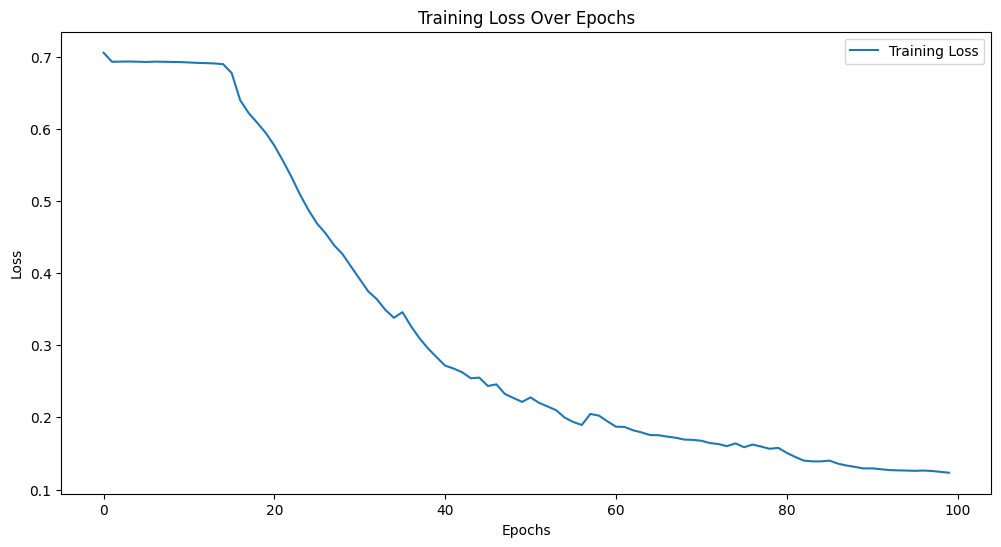

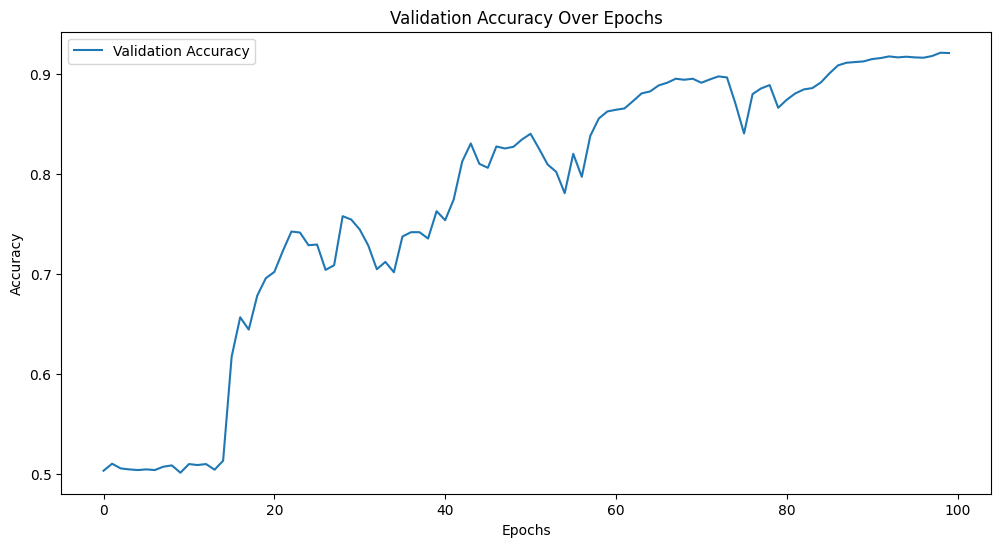

In [121]:
# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()